In [1]:
import seaborn as sns
import sdeint
import matplotlib.pyplot as plt
import pandas as pd
import sympy as smp
import random
import numpy as np
import pycatch22 as catch22
from sympy import real_roots
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.optimize import fsolve
import scipy
import statistics
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA, FactorAnalysis
from scipy.spatial.distance import pdist, squareform, cdist

# Scaling Up

- add in Linear Stochastic Processes (AR processes + Uncorrelated Noise)
- add in maps
- add in strange attractors
- add in period doubling 
- add in random walk

## Linear Stochastic Processes

In [2]:
def gen_AR1(phi, sigma, N):
    """
    Return an AR time series of mean zero and length N

    sigma = white noise standard deviation

    phi = autoregressive parameter 

    N = number of samples
    """
    # Generate initial value of the time series
    x_0 = np.random.normal() # random intiial conditions
    transient = 100 # number of transient samples to discard

    # Generate time series data
    x = np.zeros(N+transient)
    x[0] = x_0
    for i in range(1, N+transient):
        x[i] = phi * x[i-1] + sigma * np.random.normal()
    return x[transient:]

In [3]:
def sample_AR1(n_samples):
    N = np.random.uniform(50, 5000, n_samples)
    phi = np.random.uniform(-0.99, 0.99, n_samples)
    sigma = np.random.uniform(0.01, 1, n_samples)
    sols = list()
    lengths_store = list()
    for i in range(n_samples):
        sols.append(gen_AR1(phi[i], sigma[i], int(N[i])))
        lengths_store.append(len(sols[i]))

    features_ar1 = np.array([catch22.catch22_all(sols[i])['values'] for i in range(n_samples)])
    ts_ar1 = sols
    df_ar1 = pd.DataFrame(features_ar1)
    df_ar1['N'] = lengths_store
    df_ar1['phi1'] = phi
    df_ar1['sigma'] = sigma
    df_ar1['regime'] = 'AR'
    df_ar1['system'] = 'AR1'

    return ts_ar1, df_ar1

In [4]:
ts, df = sample_AR1(1000)

In [5]:
rs = RobustScaler().fit(df.iloc[:,:22])
rs_transformed = rs.transform(df.iloc[:,:22])
def sigmoid(X):
    return 1/(1+scipy.special.expit(-X))
sig_transformed = sigmoid(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
Xhat = mm_transformed
pca_fit = PCA(n_components=2).fit(Xhat)
pca = pca_fit.transform(Xhat)


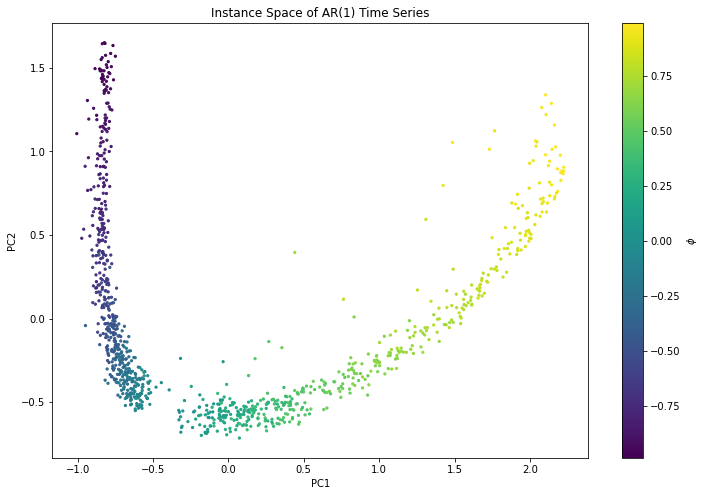

In [7]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], s=5, c=df['phi1'], cmap='viridis')
plt.title('Instance Space of AR(1) Time Series')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar().set_label('$\phi$')
plt.show()

In [4]:
def gen_AR2(phi1, phi2, sigma, N):
    """
    Return an AR2 time series of mean zero and length N
    
    sigma = white noise standard deviation

    phi1 = autoregressive parameter 1

    phi2 = autoregressive parameter 2

    N = number of samples"""

    # Generate initial value of the time series
    x_0, x_1 = np.random.random(size=2)
    transient = 100 # number of transient samples to discard

    # Generate time series data
    x = np.zeros(N+transient)
    x[0] = x_0
    x[1] = x_1
    for i in range(2, N+transient):
        x[i] = phi1 * x[i-1] + phi2 * x[i-2] + sigma * np.random.normal()
    return x[transient:]


In [5]:
def sample_AR2(n_samples):
    # AR(2) is stationary if phi1 + phi2 < 1 and phi2 - phi1 < 1 and |phi2| < 1
    # We want a good approximation of all stable, stationary AR(2) processes 

    N = np.random.uniform(50, 5000, n_samples)
    phi1_store = list()
    phi2_store = list()
    sigma_store = list()
    sols = list()
    lengths_store = list()
    count = 0
    while count < n_samples:
        phi1_proposed = np.random.uniform(-1, 1)
        phi2_proposed = np.random.uniform(-1, 1)
        if phi1_proposed + phi2_proposed < 1 and phi2_proposed - phi1_proposed < 1 and abs(phi2_proposed) < 1:
            # stable, stationary process
            phi1 = phi1_proposed
            phi2 = phi2_proposed
            sigma = np.random.uniform(0.01, 1)
            sols.append(gen_AR2(phi1, phi2, sigma, int(N[count])))
            phi1_store.append(phi1)
            phi2_store.append(phi2)
            sigma_store.append(sigma)
            lengths_store.append(len(sols[count]))
            count += 1
    features_ar2 = np.array([catch22.catch22_all(sols[i])['values'] for i in range(n_samples)])
    ts_ar2 = sols
    df_ar2 = pd.DataFrame(features_ar2)
    df_ar2['N'] = lengths_store
    df_ar2['phi1'] = phi1_store
    df_ar2['phi2'] = phi2_store
    df_ar2['sigma'] = sigma_store
    df_ar2['regime'] = 'AR'
    df_ar2['system'] = 'AR2'

    return ts_ar2, df_ar2

In [6]:
def sample_AR0(n_samples):
    """
    Sample AR(0) time series (equivalent to white noise)
    """
    N = np.random.uniform(50, 5000, n_samples)
    sigma = np.random.uniform(0.01, 1, n_samples)
    sols = list()
    lengths_store = list()
    phi1_store = list()
    for i in range(n_samples):
        sols.append(gen_AR1(phi=0, sigma=sigma[i], N=int(N[i]))) # use AR1 process and set phi to 0
        lengths_store.append(len(sols[i]))
        phi1_store.append(0)
    
    features_ar0 = np.array([catch22.catch22_all(sols[i])['values'] for i in range(n_samples)])
    ts_ar0 = sols
    df_ar0 = pd.DataFrame(features_ar0)
    df_ar0['N'] = lengths_store
    df_ar0['phi1'] = phi1_store
    df_ar0['sigma'] = sigma
    df_ar0['regime'] = 'AR'
    df_ar0['system'] = 'AR0'
    
    return ts_ar0, df_ar0
    

In [7]:
ts_ar0, df_ar0 = sample_AR0(1000)
ts_ar1, df_ar1 = sample_AR1(1000)
ts_ar2, df_ar2 = sample_AR2(1000)

In [8]:
data = pd.concat([df_ar0, df_ar1, df_ar2], axis=0)

In [9]:
rs = RobustScaler().fit(data.iloc[:,:22])
rs_transformed = rs.transform(data.iloc[:,:22])
def sigmoid(X):
    return 1/(1+scipy.special.expit(-X))
sig_transformed = sigmoid(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
Xhat = mm_transformed
pca_fit = PCA(n_components=2).fit(Xhat)
pca = pca_fit.transform(Xhat)

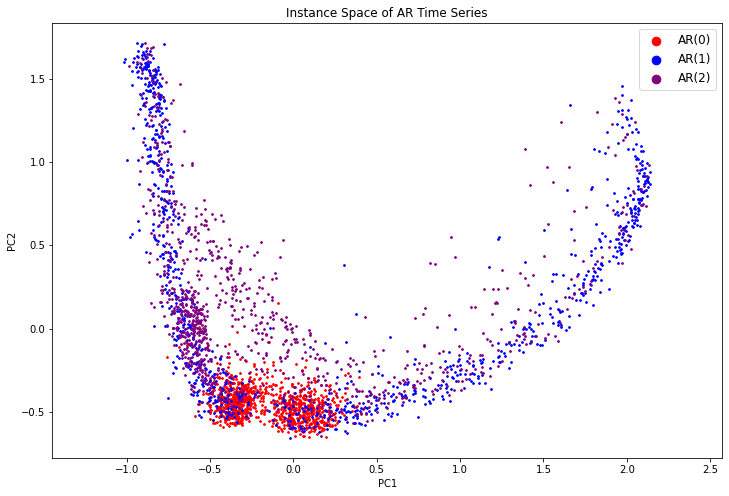

In [10]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:1000,0], pca[:1000,1], c='r', label='AR(0)', s=3)
plt.scatter(pca[1000:2000,0], pca[1000:2000,1], c='b', label='AR(1)', s=3)
plt.scatter(pca[2000:,0], pca[2000:,1], c='purple', label='AR(2)', s=3)
plt.legend(fontsize=12, markerscale=5)
plt.title('Instance Space of AR Time Series')
plt.axis('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Discrete Time Maps

Parameter values of interest for the logistic map:
- r = [1,3) = Fixed point behaviour
- r = [3, 3.56994567) = Period doubling cascade
- r = [3.57, 4) = Chaos (generally)
- r = [3.57, 3.82843) = Itermittency
- r = [3.82844, 3.8415) = Periodic window

In [11]:
def gen_LogisticMap(mu, eta, N):
    """
    Generate time series from a logistic map of length N

    mu = control parameter (chaotic dynamics for mu = [3.569945, 4])

    eta = additive measurment noise parameter/variance value of error term (eta = 0 for deterministic dynamics)
    """
    x_0 = np.random.uniform(low=0.01, high=1)
    transient = 100 # number of transient samples to discard to ensure trajectories are on the attrractor

    x = np.zeros(N+transient)
    x[0] = x_0
    for i in range(1, N+transient):
        x[i] = mu*x[i-1]*(1-x[i-1])
    
    return x[transient:] + np.random.normal(0, eta, N)

In [12]:
def sample_chaos(mu, eta, n_samples):
    """
    Sample chaotic dynamics from the following systems:
    - Logistic Map
    """
    N = np.tile(5000, n_samples)
    mu = np.tile(mu, n_samples)
    eta = np.tile(eta, n_samples)
    sols = list()
    lengths_store = list()
    for i in range(n_samples):
        sols.append(gen_LogisticMap(mu[i], eta[i], int(N[i])))
        lengths_store.append(len(sols[i]))
    
    features_chaos = np.array([catch22.catch22_all(sols[i])['values'] for i in range(n_samples)]) 
    ts_chaos = sols
    df_chaos = pd.DataFrame(features_chaos)
    df_chaos['N'] = lengths_store
    df_chaos['mu'] = mu
    df_chaos['eta'] = eta
    df_chaos['regime'] = 'Chaos'
    df_chaos['system'] = 'LogisticMap'

    return ts_chaos, df_chaos

In [13]:
ts1, df1 = sample_chaos(4, 0., 100)
ts2, df2 = sample_chaos(3.83, 0., 100)
ts3, df3 = sample_chaos(1.5, 0.01, 100)
ts4, df4 = sample_chaos(3.2, 0., 100)

In [53]:
ts5, df5 = sample_chaos(3.4, 0., 100)

In [54]:
data = pd.concat([df1, df2, df3, df4,df5], ignore_index=True)

In [55]:
rs = RobustScaler().fit(data.iloc[:,:22])
rs_transformed = rs.transform(data.iloc[:,:22])
def sigmoid(X):
    return 1/(1+scipy.special.expit(-X))
sig_transformed = sigmoid(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
Xhat = mm_transformed
pca_fit = PCA(n_components=2).fit(Xhat)
pca = pca_fit.transform(Xhat)

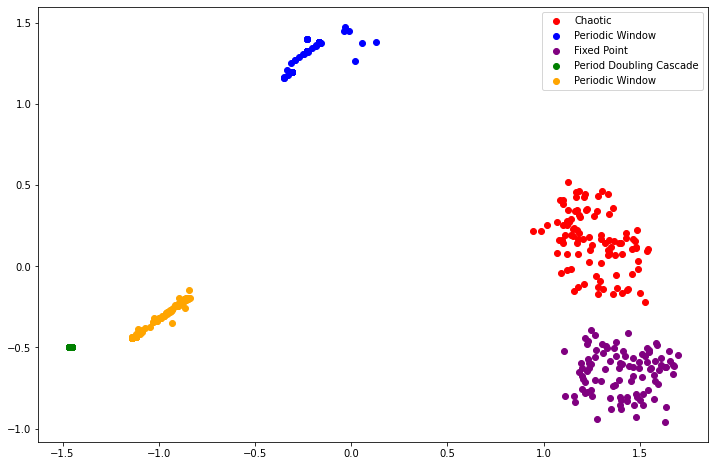

In [56]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:100,0], pca[:100,1], c='r', label='Chaotic')
plt.scatter(pca[100:200,0], pca[100:200,1], c='b', label='Periodic Window')
plt.scatter(pca[200:300,0], pca[200:300,1], c='purple', label='Fixed Point')
plt.scatter(pca[300:400, 0], pca[300:400, 1], c='g', label='Period Doubling Cascade')
plt.scatter(pca[400:, 0], pca[400:, 1], c='orange', label='Periodic Window')
plt.legend()

In [664]:
def sample_LogMap(n_samples):
    N = np.tile(1000, n_samples)
    mu = np.linspace(2.8, 4, n_samples)
    eta = np.tile(0.1, n_samples)
    sols = list()
    lengths_store = list()
    regime_store = list()
    for i in range(n_samples):
        sols.append(gen_LogisticMap(mu[i], eta[i], int(N[i])))
        lengths_store.append(len(sols[i][0]))

        # check for regime
        if mu[i] < 3:
            regime_store.append('FixedPoint')
        if mu[i] > 3 and mu[i] < 3.569945:
            regime_store.append('PeriodDoubling')
        if mu[i] > 3.569945:
            regime_store.append('Chaos')
    
    features_chaos = np.array([catch22.catch22_all(sols[i])['values'] for i in range(n_samples)])
    ts_chaos = sols
    df_chaos = pd.DataFrame(features_chaos)
    df_chaos['N'] = lengths_store
    df_chaos['mu'] = mu
    df_chaos['eta'] = eta
    df_chaos['regime'] = regime_store
    df_chaos['system'] = 'LogisticMap'

    return ts_chaos, df_chaos
    

In [447]:
ts_log, df_log = sample_LogMap(5000)

In [450]:
rs = RobustScaler().fit(df_log.iloc[:,:22])
rs_transformed = rs.transform(df_log.iloc[:,:22])
def sigmoid(X):
    return 1/(1+scipy.special.expit(-X))
sig_transformed = sigmoid(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
Xhat = mm_transformed
pca_fit = PCA(n_components=2).fit(Xhat)
pca = pca_fit.transform(Xhat)

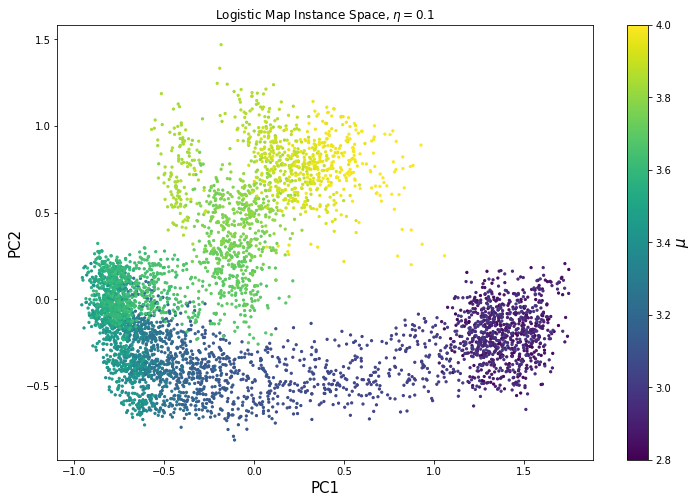

In [451]:
plt.figure(figsize=(12,8))
plt.title('Logistic Map Instance Space, $\eta=0.1$')
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.scatter(pca[:,0], pca[:,1], c=df_log['mu'], s=5)
plt.colorbar().set_label('$\mu$', fontsize=15)
plt.show()

In [452]:
im_mask = df_log[(df_log['mu'] > 3.569945) & (df_log['mu'] < 3.65)].index # examine the presence of intermittency
fp_mask = df_log[df_log['regime'] == 'FixedPoint'].index
pd_mask = df_log[df_log['regime'] == 'PeriodDoubling'].index
chaos_mask = df_log[df_log['regime'] == 'Chaos'].index

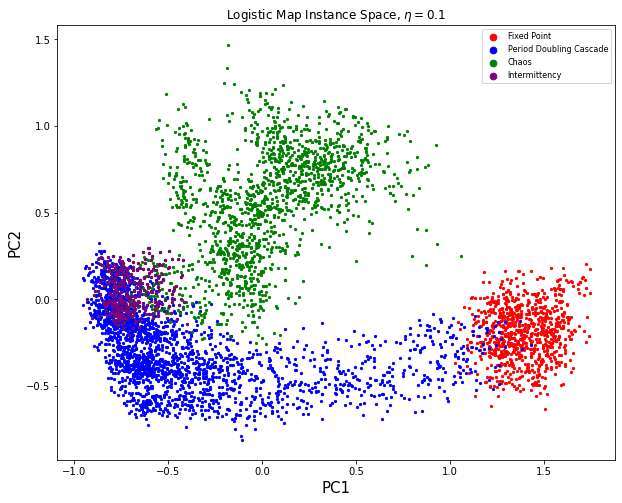

In [453]:
plt.figure(figsize=(10,8))
plt.title('Logistic Map Instance Space, $\eta = 0.1$')
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.scatter(pca[fp_mask,0], pca[fp_mask,1], c='r', s=5, label='Fixed Point')
plt.scatter(pca[pd_mask,0], pca[pd_mask,1], c='b', s=5, label='Period Doubling Cascade')
plt.scatter(pca[chaos_mask,0], pca[chaos_mask,1], c='g', s=5, label='Chaos')
plt.scatter(pca[im_mask,0], pca[im_mask,1], c='purple', s=5, label='Intermittency')
plt.legend(markerscale=3, fontsize=8)
plt.show()

Henon Map

In [724]:
def gen_HenonMap(a, N, eta, b=0.3):
    """Generate time series from a two dimensional Henon map of length N
    """
    x_0 = np.random.uniform(low=0.01, high=1) # random initial condition
    y_0 = np.random.uniform(low=0.01, high=1)
    transient = 100 # number of transient samples to discard to ensure trajectories are on the attrractor

    x = np.zeros(N+transient)
    y = np.zeros(N+transient)
    x[0] = x_0
    y[0] = y_0
    for i in range(1, N+transient):
        x[i] = 1 - a*x[i-1]**2 + y[i-1]
        y[i] = b*x[i-1]
    
    return x[transient:] + np.random.normal(0, eta, N), y[transient:] + np.random.normal(0, eta, N)

Henon Map parameter ranges:
- [0, 0.3675] = Fixed Point
- [0.3675, 1.05] = Period Doubling Cascade
- [1.05, 1.4] = Chaos (generally, however periodic windows exist throughout ie. a = 1.25, 1.3)

In [663]:
def sample_HenonMap(n_samples):
    eta = np.tile(0.1, n_samples)
    mu = np.linspace(0, 1.4, n_samples)
    N = np.tile(1000, n_samples)
    sols = list()
    lengths_store = list()
    regime_store = list()
    for i in range(n_samples):
        sols.append(gen_HenonMap(mu[i], int(N[i]), eta[i]))
        lengths_store.append(len(sols[i][0]))
        
        # check for regime
        if mu[i] < 0.3675:
            regime_store.append('FixedPoint')
        if mu[i] > 0.3675 and mu[i] < 1.05:
            regime_store.append('PeriodDoubling')
        if mu[i] > 1.05:
            regime_store.append('Chaos')
    
    features_chaos = np.array([catch22.catch22_all(sols[i][0])['values'] for i in range(n_samples)])
    ts_chaos = sols
    df_chaos = pd.DataFrame(features_chaos)
    df_chaos['N'] = lengths_store
    df_chaos['mu'] = mu
    df_chaos['eta'] = eta
    df_chaos['regime'] = regime_store
    df_chaos['system'] = 'HenonMap'

    return ts_chaos, df_chaos
    

In [442]:
ts_henon, df_henon = sample_HenonMap(5000)

In [472]:
rs = RobustScaler().fit(df_henon.iloc[:,:22])
rs_transformed = rs.transform(df_henon.iloc[:,:22])
def sigmoid(X):
    return 1/(1+scipy.special.expit(-X))
sig_transformed = sigmoid(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
Xhat = mm_transformed
pca_fit = PCA(n_components=2).fit(Xhat)
pca = pca_fit.transform(Xhat)

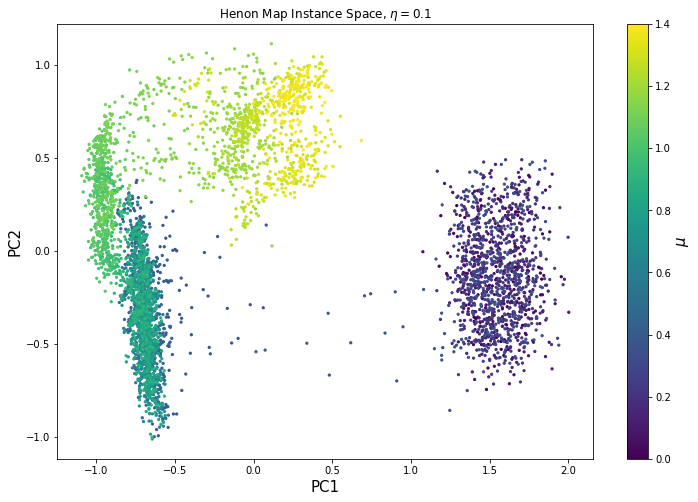

In [479]:
plt.figure(figsize=(12,8))
plt.title('Henon Map Instance Space, $\eta = 0.1$')
plt.scatter(pca[:,0], pca[:,1], c=df_henon['mu'], s=5)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.colorbar().set_label('$\mu$', fontsize=15)
plt.show()

In [477]:
fp_mask = df_henon[df_henon['regime'] == 'FixedPoint'].index
pd_mask = df_henon[df_henon['regime'] == 'PeriodDoubling'].index
chaos_mask = df_henon[df_henon['regime'] == 'Chaos'].index

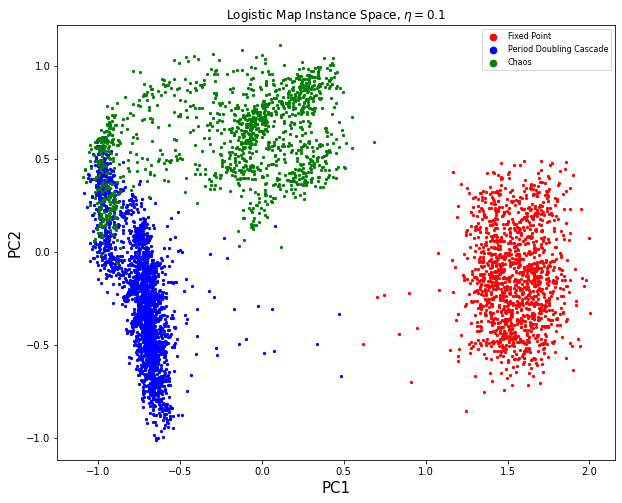

In [478]:
plt.figure(figsize=(10,8))
plt.title('Henon Map Instance Space, $\eta = 0.1$')
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.scatter(pca[fp_mask,0], pca[fp_mask,1], c='r', s=5, label='Fixed Point')
plt.scatter(pca[pd_mask,0], pca[pd_mask,1], c='b', s=5, label='Period Doubling Cascade')
plt.scatter(pca[chaos_mask,0], pca[chaos_mask,1], c='g', s=5, label='Chaos')
plt.legend(markerscale=3, fontsize=8)
plt.show()

In [649]:
def gen_ikedaMap(u,N, eta):
    """
    Generate time series from the Ikeda map of length N
    """

    x_0 = np.random.uniform(low=0.01, high=1) # random initial condition
    y_0 = np.random.uniform(low=0.01, high=1)
    transient = 100 # number of transient samples to discard to ensure trajectories are on the attrractor

    x = np.zeros(N+transient)
    y = np.zeros(N+transient)
    x[0] = x_0
    y[0] = y_0
    for i in range(1, N+transient):
        theta = 0.4 - 6/(1 + x[i-1]**2 + y[i-1]**2)
        x[i] = 1 + u*(x[i-1]*np.cos(theta) - y[i-1]*np.sin(theta))
        y[i] = u*(x[i-1]*np.sin(theta) + y[i-1]*np.cos(theta))
    
    return x[transient:] + np.random.normal(0, eta, N), y[transient:] + np.random.normal(0, eta, N)

In [710]:
def sample_ikedaMap(n_samples):
    N = np.tile(1000, n_samples)
    eta = np.tile(0.1, n_samples)
    mu = np.linspace(0, 0.9, n_samples)
    sols = list()
    lengths_store = list()
    regime_store = list()
    for i in range(n_samples):
        sols.append(gen_ikedaMap(mu[i], N[i], eta[i]))
        lengths_store.append(len(sols[i][0]))
        
        # check for regime
        if mu[i] < 0.41:
            regime_store.append('FixedPoint')
        if mu[i] >= 0.41 and mu[i] < 0.64:
            regime_store.append('PeriodDoubling')
        if mu[i] > 0.64:
            regime_store.append('Chaos')
    
    features_chaos = np.array([catch22.catch22_all(sols[i][0])['values'] for i in range(n_samples)])
    ts_chaos = sols
    df_chaos = pd.DataFrame(features_chaos)
    df_chaos['N'] = lengths_store
    df_chaos['eta'] = eta
    df_chaos['mu'] = mu
    df_chaos['regime'] = regime_store
    df_chaos['system'] = 'IkedaMap'

    return ts_chaos, df_chaos
    

In [711]:
ts_ikeda, df_ikeda = sample_ikedaMap(5000)

In [712]:
rs = RobustScaler().fit(df_ikeda.iloc[:,:22])
rs_transformed = rs.transform(df_ikeda.iloc[:,:22])
def sigmoid(X):
    return 1/(1+scipy.special.expit(-X))
sig_transformed = sigmoid(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
Xhat = mm_transformed
pca_fit = PCA(n_components=2).fit(StandardScaler().fit_transform(df_ikeda.iloc[:,:22]))
pca = pca_fit.transform(StandardScaler().fit_transform(df_ikeda.iloc[:,:22]))

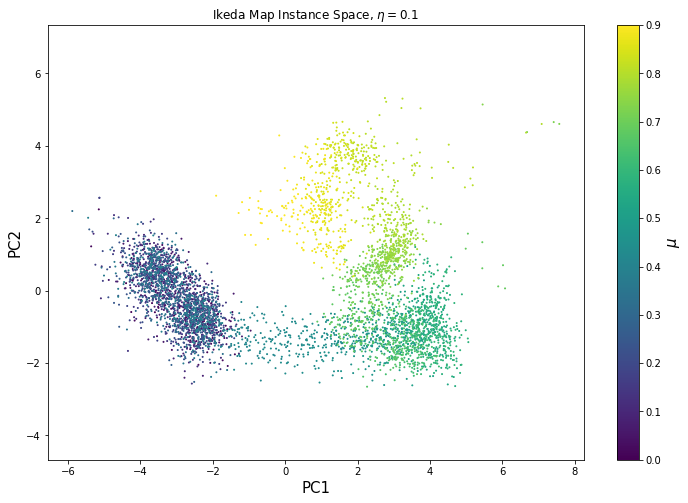

In [723]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], c=df_ikeda['mu'], s=1)
plt.title('Ikeda Map Instance Space, $\eta = 0.1$')
plt.colorbar().set_label('$\mu$', fontsize=15)
plt.axis('equal')
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.show()

In [715]:
fp_mask = df_ikeda[df_ikeda['regime'] == 'FixedPoint'].index
pd_mask = df_ikeda[df_ikeda['regime'] == 'PeriodDoubling'].index
chaos_mask = df_ikeda[df_ikeda['regime'] == 'Chaos'].index

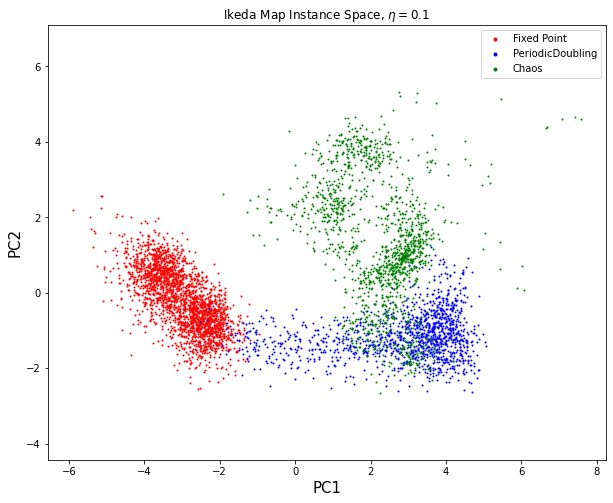

In [722]:
plt.figure(figsize=(10,8))
plt.scatter(pca[fp_mask,0], pca[fp_mask,1], c='r', s=1, label='Fixed Point')
plt.scatter(pca[pd_mask,0], pca[pd_mask,1], c='b', s=1, label='PeriodicDoubling')
plt.scatter(pca[chaos_mask,0], pca[chaos_mask,1], c='g', s=1, label='Chaos')
plt.legend(markerscale=3)
plt.title('Ikeda Map Instance Space, $\eta = 0.1$')
plt.axis('equal')
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.show()

Combine all three to sample from periodic doubling regime, fixed point and chaos as meta classes of dynamics

# Multi-Stability

Equations and paramters taken from Kraut, S., Feudel, U., & Grebogi, C. (1999). Preference of attractors in noisy multistable systems.

In [963]:
def gen_multistable(nu, f0, eta, N):

    x_0 = np.random.normal()
    y_0 = np.random.normal()

    transient = 100
    x = np.zeros(N+transient)
    y = np.zeros(N+transient) 

    x[0] = x_0
    y[0] = y_0
    
    for i in range(1, N+transient):
        x[i] = np.mod(x[i-1] + y[i-1] + eta*np.random.normal(), 2*np.pi)
        y[i] = (1 - nu) * y[i-1] + f0 * np.sin(x[i-1] + y[i-1]) + eta*np.random.normal()

    return y[transient:] # only interested in the y-component

In [984]:
x = gen_multistable(0.02, 3.5, 0.1, 5000)

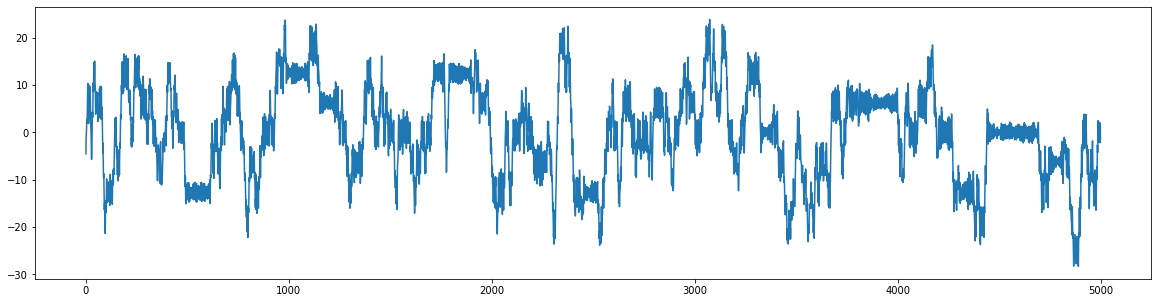

In [985]:
plt.figure(figsize=(20,5))
plt.plot(x)